## Multilabel Classification of Reviews

Dataset Source: https://www.kaggle.com/datasets/mohamedziauddin/mh-uhack-sentiments

#### Install Missing Libraries

In [1]:
%pip install tensorboard transformers torch
%pip install scikit-learn datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.9 MB/s eta 0:00:00

#### Import Necessary Libraries

In [2]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

import transformers
from transformers import DataCollatorForSeq2Seq, AutoTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer, set_seed

import datasets
from datasets import Dataset, DatasetDict

import evaluate

import torch

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### Display Version of Relevant Libraries

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("NumPy:".rjust(15), np.__version__)
print("Torch:".rjust(15), transformers.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.16
        Pandas: 1.4.4
         NumPy: 1.22.4
         Torch: 4.27.1
  Transformers: 4.27.1
      Datasets: 2.10.1
      Evaluate: 0.4.0


#### HuggingFace Access

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

#### Mount Google Drive to Notebook

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Ingest Data & Drop Unnecessary Feature

In [9]:
parent_dir = "/content/drive/MyDrive/Colab Notebooks/multilabel classification"

df = pd.read_csv(os.path.join(parent_dir, "train.csv"))

df.drop(columns=["Id"], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6136 entries, 0 to 6135
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Review                         6136 non-null   object
 1   Components                     6136 non-null   int64 
 2   Delivery and Customer Support  6136 non-null   int64 
 3   Design and Aesthetics          6136 non-null   int64 
 4   Dimensions                     6136 non-null   int64 
 5   Features                       6136 non-null   int64 
 6   Functionality                  6136 non-null   int64 
 7   Installation                   6136 non-null   int64 
 8   Material                       6136 non-null   int64 
 9   Price                          6136 non-null   int64 
 10  Quality                        6136 non-null   int64 
 11  Usability                      6136 non-null   int64 
 12  Polarity                       6136 non-null   int64 
dtypes: 

#### Check Some Examples

In [10]:
df.head()

,Review,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
0,For some reason everybody complains and I'm co...,0,0,0,0,0,0,0,0,0,0,1,0
1,"I like everything about it, great choice of sp...",0,0,0,0,1,1,0,0,0,0,0,1
2,Excellent ceiling fan brace. Easy to install a...,0,0,0,0,0,0,1,0,0,1,0,1
3,Work great easy to use . No issues at all with...,0,0,0,0,0,1,0,0,0,0,1,1
4,I would recommend this product because it is p...,0,0,0,0,0,0,0,0,0,1,0,1


#### Visual: Histogram of Input Word Lengths

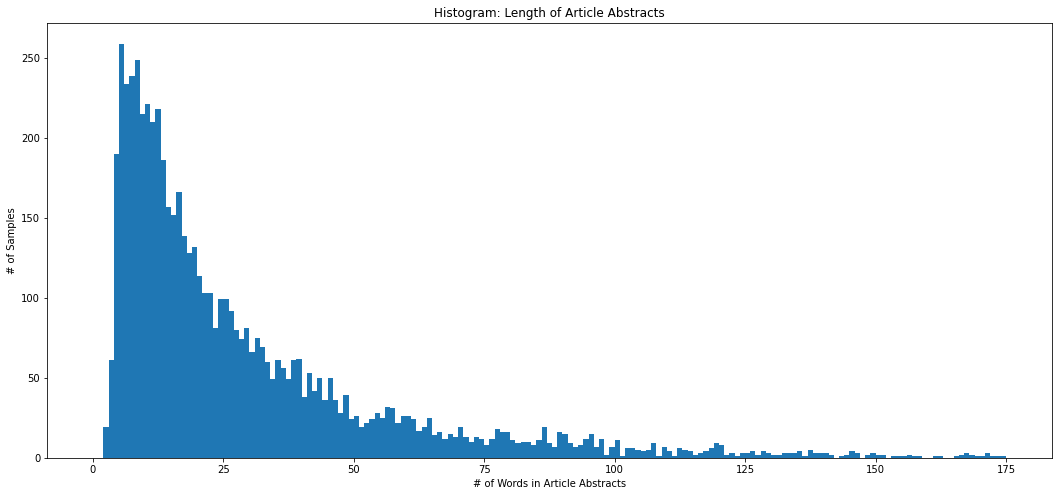

The maximum length of Article Abstracts (in words) is 374 words.


In [11]:
df['text_length'] = df['Review'].str.split().str.len()

n_bin=175
df.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Article Abstracts')
plt.xlabel('# of Words in Article Abstracts')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Article Abstracts (in words) is {max(df['text_length'])} words.")

#### Data Preprocessing

In [12]:
upper_limit=176

df = df[df['text_length'] < upper_limit]

df.drop(columns=["text_length"], inplace=True)

df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6092 entries, 0 to 6091
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Review                         6092 non-null   object
 1   Components                     6092 non-null   int64 
 2   Delivery and Customer Support  6092 non-null   int64 
 3   Design and Aesthetics          6092 non-null   int64 
 4   Dimensions                     6092 non-null   int64 
 5   Features                       6092 non-null   int64 
 6   Functionality                  6092 non-null   int64 
 7   Installation                   6092 non-null   int64 
 8   Material                       6092 non-null   int64 
 9   Price                          6092 non-null   int64 
 10  Quality                        6092 non-null   int64 
 11  Usability                      6092 non-null   int64 
 12  Polarity                       6092 non-null   int64 
dtypes: 

<ipython-input-12-1ae5eb2cc774>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["text_length"], inplace=True)


#### Create List of Labels & Dictionaries for Converting Between Strings & Integers

In [13]:
labels = [x for x in df.columns if x not in ['Review', "Id"]]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
NUM_OF_LABELS = len(labels)

#### Convert Pandas DataFrame to Datasets & Split Dataset into Training/Testing/Evaluation Datasets

In [14]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)
ds['train'][25]

Training Dataset Shape: (4873, 13)
Testing Dataset Shape: (609, 13)
Evaluation Dataset Shape: (610, 13)


{'Review': 'Poor casting, poor machining, weak jaws.  Going to return.  Fooled by Bessey name that was previously well respected.',
 'Components': 1,
 'Delivery and Customer Support': 0,
 'Design and Aesthetics': 0,
 'Dimensions': 0,
 'Features': 0,
 'Functionality': 0,
 'Installation': 0,
 'Material': 0,
 'Price': 0,
 'Quality': 1,
 'Usability': 0,
 'Polarity': 0}

#### Basic Values/Constants

In [15]:
set_seed = 42
NUM_OF_EPOCHS = 10

BATCH_SIZE = 16
LEARNING_RATE = 2e-5

MAX_LENGTH = int(round((upper_limit - 1) * 1.3, 0))
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"

MODEL_CKPT = "bert-base-uncased"
MODEL_NAME = MODEL_CKPT + "-uHack_reviews_multilabel_clf"

METRIC_NAME = "f1"
DEVICE = torch.device("cuda")

print(f"This project will utilize the {DEVICE} to train and evaluate.")
print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")

This project will utilize the cuda to train and evaluate.
This project will have a maximum length for the input text of 228 tokens.


#### Create Tokenizer

In [16]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def data_preprocessor(examples):
	# take a batch of text
	text = examples["Review"]
	# encode them
	encoded_data = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LENGTH)
	# add labels
	labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
	# create numpy array of shape (batch_size, num_labels)
	labels_matrix = np.zeros((len(text), len(labels)))
	# fill numpy array	
	for idx, label in enumerate(labels):
		labels_matrix[:, idx] = labels_batch[label]

	encoded_data["labels"] = labels_matrix.tolist()
  
	return encoded_data

#### Tokenize Dataset

In [17]:
encoded_ds = ds.map(data_preprocessor, batched=True, load_from_cache_file=False)
encoded_ds.set_format("torch")

Map:   0%|          | 0/4873 [00:00<?, ? examples/s]

Map:   0%|          | 0/609 [00:00<?, ? examples/s]

Map:   0%|          | 0/610 [00:00<?, ? examples/s]

#### Print Dataset Shapes to Make Sure

In [18]:
print(f"The shape of the training dataset is: {encoded_ds['train'].shape}")
print(f"The shape of the testing dataset is: {encoded_ds['test'].shape}")
print(f"The shape of the evaluation dataset is: {encoded_ds['eval'].shape}")

The shape of the training dataset is: (4873, 17)
The shape of the testing dataset is: (609, 17)
The shape of the evaluation dataset is: (610, 17)


#### Define Model

In [19]:
model = (BertForSequenceClassification.from_pretrained(MODEL_CKPT, 
                                                             num_labels=NUM_OF_LABELS, 
                                                             problem_type="multi_label_classification",
                                                             id2label=id2label,
                                                             label2id=label2id)
         ).to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### Create Metrics Evaluation Function

In [20]:
def multi_label_metrics(predictions, 
                        labels, 
                        threshold=0.5):
    '''
    This function calculates & returns metrics 
    for a multilabel classification analysis.
    '''
    
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return metrics as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    preds = preds[0] if isinstance(preds, 
                    tuple) else preds
    results = multi_label_metrics(
                    predictions=preds, 
                    labels=labels)
    return results

#### Define Training Arguments

In [21]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    load_best_model_at_end=True,
    metric_for_best_model=METRIC_NAME,
    greater_is_better=True,
    report_to=REPORTS_TO,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_first_step=True,
    hub_private_repo=True,
    push_to_hub=True
)

#### Instantiate Trainer

In [22]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-uHack_reviews_multilabel_clf into local empty directory.


#### Train Model

In [23]:
training_results = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.340900,0.245264,0.771684,0.828391,0.378689
2,0.204900,0.190579,0.838899,0.879565,0.506557
3,0.151900,0.170688,0.859486,0.899230,0.544262
4,0.117600,0.157540,0.859165,0.901184,0.545902
5,0.093000,0.154399,0.864654,0.903402,0.565574
6,0.075200,0.154999,0.863004,0.908415,0.565574
7,0.062900,0.151479,0.873651,0.914636,0.596721
8,0.053800,0.148666,0.871706,0.914548,0.585246
9,0.048100,0.150180,0.871404,0.914463,0.583607
10,0.044700,0.149864,0.871458,0.915398,0.585246


#### Evaluate Model

In [24]:
trainer.evaluate()

{'eval_loss': 0.15147870779037476,
 'eval_f1': 0.8736512356421859,
 'eval_roc_auc': 0.9146361848391104,
 'eval_accuracy': 0.5967213114754099,
 'eval_runtime': 8.3384,
 'eval_samples_per_second': 73.155,
 'eval_steps_per_second': 4.677,
 'epoch': 10.0}

#### Push Model to HuggingFace Hub (My Profile!)

In [25]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/418M [00:00<?, ?B/s]

Upload file runs/Mar19_01-40-57_d5d359cd3d4c/events.out.tfevents.1679190064.d5d359cd3d4c.612.0: 100%|#########…

Upload file runs/Mar19_01-40-57_d5d359cd3d4c/events.out.tfevents.1679192411.d5d359cd3d4c.612.2: 100%|#########…

To https://huggingface.co/DunnBC22/bert-base-uncased-uHack_reviews_multilabel_clf
   dcd7e4c..fc2bdf6  main -> main

   dcd7e4c..fc2bdf6  main -> main

To https://huggingface.co/DunnBC22/bert-base-uncased-uHack_reviews_multilabel_clf
   fc2bdf6..e2fee44  main -> main

   fc2bdf6..e2fee44  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-uHack_reviews_multilabel_clf/commit/fc2bdf62e88205a3f3b4b9efb08867018fdcbbdf'

### Citation

- Model Checkpoint
> @article{DBLP:journals/corr/abs-1810-04805,
  author    = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title     = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding},
  journal   = {CoRR},
  volume    = {abs/1810.04805},
  year      = {2018},
  url       = {http://arxiv.org/abs/1810.04805},
  archivePrefix = {arXiv},
  eprint    = {1810.04805},
  timestamp = {Tue, 30 Oct 2018 20:39:56 +0100},
  biburl    = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}
